### 2025 Spring | IEORE4524 | Analytics in Practice | Project Final Version
### Group: ZipLine P1 | Team Members: Kelly Chen, Shuting Fang, Zijun Xu, Lily Zhang

# Preparation

## Dependencies

Before running for the first time, install the dependencies. Open terminal and run the `pip install` command:

In [1]:
# !pip install ipywidgets

In [2]:
# !pip install simpy

In [3]:
# import packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
import simpy
from typing import Optional
from dataclasses import dataclass
import ipywidgets as widgets
from IPython.display import display, clear_output

## Global Settings

### Fixed Parameters

The following parameters are set to a constant number.

#### Operators Numbers

In [4]:
# number of call operators
N_CALL_OPS = 3
# number of pick-up operators
N_PICK_OPS = 3
# number of assemble operators (who also launch the zip)
N_ASSM_OPS = 1
# number of recovery operators
N_RECO_OPS = 1

#### Harderware Numbers

In [5]:
# number of zips in all 
N_ZIPS      = 18
# number of zips reserved for emergency orders (included in the upper one)
N_ZIPS_EM   = 2
# number of batteries in all
N_BATTS     = 40
# number of batteries reserved for emergency orders (included in the upper one)
N_BATTS_EM  = 2
# number of batteries' chargers
N_CHRGRS    = 20
# number of launchers
N_LNCHRS    = 1

#### Simulation Time

In [6]:
# time of simulation process
HR_STT  = 7                     # the hour simulation start at
HR_CLS  = 17                    # the hour nest close to stop accepting new orders
HRS_GEN = HR_CLS - HR_STT       # total time of order generation in hours
T_GEN   = HRS_GEN * 60 * 60     # converted into seconds
HRS_SIM = 12                    # total time of simulation in hours
T_SIM   = HRS_SIM * 60 * 60     # converted into seconds

#### Priority Types

In [7]:
# priority types are basically: 1. Emergency; 2. Scheduled; 3. End Of Day (EOD)
PRIO_LST = ['Emergency', 'Scheduled', 'EOD']

### Normal-Distributed Parameters

The following parameters randomly vary from average - using truncated normal distribution.

#### Operating Times

In [8]:
# call operating time (s)
T_CALL_AVG = 300
T_CALL_STD = 120
# pick-up operating time (s) for non-vaccine deliveries
T_PICK_AVG_NON = 300
T_PICK_STD_NON = 60
# pick-up operating time (s) for vaccine deliveries
T_PICK_AVG_VAC = 600
T_PICK_STD_VAC = 100
# assemble operating time (s)
T_ASSM_AVG = 180
T_ASSM_STD = 60
# launch operating time (s)
T_LNCH_AVG = 20
T_LNCH_STD = 5
# recovery operating time (s)
T_RECO_AVG = 120
T_RECO_STD = 30

#### Hardware Performance

In [9]:
# flying speed of zips (m/s)
# wind speed disturbance simplified in overall flucuatioin 
V_ZIP_AVG   = 24
V_ZIP_STD   = 4
V_ZIP_MIN   = 1
# charging to full time for batteries (s)
T_CHRG_AVG  = 30 * 60
T_CHRG_STD  = 10 * 60

#### Orders Properties

In [10]:
# flying distances (km)
D_AVG = 50
D_STD = 20
D_MIN = 2
D_MAX = 100

In [11]:
# total weights of orders (kg)
W_AVG   = 1
W_STD   = 0.1
W_MIN   = 0.1
# weight of package (kg)
W_1     = 0.2
# weight of parcel (kg)
W_2     = 0.1
# weight capacity of each delivery (kg)
W_CAP   = 1.5 - W_1 - W_2

In [12]:
# deliveries time window of schelduled orders (s)
WIN_SLOT    = 30 * 60       # minimum slot of time window: 30 min
WIN_LEN     = 2 * 60 * 60   # length of time window: 2 h
WIN_LAG_AVG = 4 * 60 * 60   # window start is on average 4 hours after time of order placing
WIN_LAG_STD = 2 * 60 * 60   # standard deviation of time the window start after time of order placing is 2 hour

In [13]:
# parameters deciding vaccine probability
P_VAC       = 0.1   # base probability of vaccine
D_CC        = 50    # distance threshold for cold-chain
Q_VAC_CC    = 2.5   # boost factor of vaccine probability if cold-chain
Q_VAC_EM    = 3.0   # boost factor of vaccine probability if emergency

## Key Param Editors

### Order Distribution Editor

In [14]:
def hrdist_gen(n, n_sigma:float=4.0, noise_pct:float=0.1):
    # compute base normal PDF values centered at middle index
    mid = (n - 1) / 2.0
    sigma = n / n_sigma  # controls spread
    raw = stats.norm.pdf(np.arange(n), loc=mid, scale=sigma).tolist()
    total_raw = sum(raw)
    base = [p / total_raw for p in raw]
    # add slight uniform noise to randomize
    noise_pct = 0.1
    noise = [p * (1 + np.random.uniform(-noise_pct, noise_pct)) for p in base]
    total_noise = sum(noise)
    perturbed = [p / total_noise for p in noise]
    # round to 2 decimals
    dist = [round(p, 2) for p in perturbed]
    # distribute rounding error randomly among slots
    diff = 1.0 - sum(dist)
    steps = int(round(diff / 0.01))  # number of 0.01 units to adjust
    if steps != 0:
        # randomly select slots (with replacement) to adjust
        indices = np.random.choice(n, abs(steps), replace=True)
        for idx in indices:
            dist[idx] = round(dist[idx] + np.sign(steps) * 0.01, 2)
    return dist

In [15]:
class OrderDistInput:
    # Order Distribution Input component
    # Supports a customizable number of hours (n_hours start at start_hour)
    # Validates inputs and saves the distribution on widgets.Button click
    def __init__(self, hr_start=None, hr_close=None, default_dist=None):
        # order generation starting hour, i.e. simulation beginning hour
        self.start_hour = hr_start if hr_start is not None else HR_STT
        # order generation closing hour
        self.close_hour = hr_close if hr_close is not None else HR_CLS
        # number of order generation hours
        self.n_hours = self.close_hour - self.start_hour
        # generate a bell-shaped default distribution with 0.01 granularity
        self.default_dist = default_dist if default_dist is not None else hrdist_gen(self.n_hours)
        # shorthand lists for inputs and error labels
        self.inps = []
        self.errs = []
        # widget setup: title, total label, error summary, save Button, output area
        self.title = widgets.HTML(value="<h2 style='font-weight:bold;'>Hourly Order Distribution Input</h2>")
        self.lbl_total = widgets.HTML(value="<b>Current Total: 0.0000</b>")
        self.lbl_error = widgets.HTML(value="", layout=widgets.Layout(color='red', font_weight='bold'))
        self.btn_save = widgets.Button(description="Save Distribution", button_style='success')
        self.btn_save.on_click(self._on_save)
        self.out = widgets.Output()
        self.saved_dist = self.default_dist  # will hold the saved distribution
        self._build_ui(self.default_dist)  # construct UI

    def _build_ui(self, default_dist):
        rows = []
        for i in range(0, self.n_hours, 4):
            row_items = []
            for j in range(i, min(i+4, self.n_hours)):
                hour = self.start_hour + j
                desc = f"{hour:02d}:00-{hour+1:02d}:00"
                ft = widgets.FloatText(
                    value=default_dist[j],
                    description=desc,
                    min=0.0, max=1.0, step=0.01,
                    layout=widgets.Layout(width='160px'),
                    style={'description_width': '80px'}
                )
                ft.observe(self._update_total, names='value')
                self.inps.append(ft)
                row_items.append(ft)
            rows.append(widgets.HBox(row_items, layout=widgets.Layout(margin='2px')))
        # assemble UI: sum label, inputs, Button, output
        self.ui = widgets.VBox([
            self.title,
            self.lbl_total,
            *rows,
            widgets.HBox([self.btn_save]),
            self.lbl_error,
            self.out
        ])
        self._update_total()


    def display(self):
        # display the widget UI
        display(self.ui)

    def _update_total(self, change=None):
        # update the sum label in bold
        total = sum(ft.value or 0 for ft in self.inps)
        self.lbl_total.value = f"<b>Current sum: {total:.4f}</b>"
        # clear previous messages
        self.lbl_error.value = ""
        with self.out:
            clear_output()

    def _validate(self):
        # validate inputs and sum to 1, return list of error strings
        errors = []
        total = 0.0
        for idx, ft in enumerate(self.inps):
            v = ft.value
            hour = self.start_hour + idx
            label = f"{hour:02d}:00-{hour+1:02d}:00"
            if v is None or v < 0 or v > 1:
                errors.append(f"{label} Value must be between 0 and 1")
            else:
                total += v
        if abs(total - 1) > 1e-6:
            errors.append(f"Total sum {total:.4f} ≠ 1")
        return errors

    def get_dist(self):
        # return current distribution list
        return [ft.value for ft in self.inps]

    def _on_save(self, b):
        # handle save widgets.Button click: validate then display errors or success
        errs = self._validate()
        if errs:
            # display first error in red bold, then generic message
            msg = errs[0] + '<br>Please correct the errors and retry'
            self.lbl_error.value = f"<span style='color:red; font-weight:bold;'>{msg}</span>"
        else:
            self.saved_dist = self.get_dist()
            global ORDER_DIST
            ORDER_DIST = self.saved_dist
            with self.out:
                clear_output()
                print("Distribution saved")
            self.lbl_error.value = ""  # clear errors

### Order Distribution Input

In [16]:
order_dist_input = OrderDistInput()
order_dist_input.display()

In [17]:
ORDER_DIST = order_dist_input.saved_dist
ORDER_DIST

[0.03, 0.07, 0.09, 0.13, 0.18, 0.18, 0.12, 0.1, 0.07, 0.03]

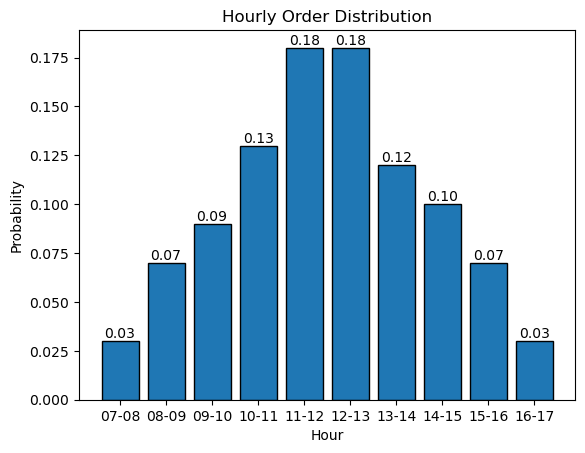

In [18]:
# Generate hour labels
start_hour = order_dist_input.start_hour
n_hours = order_dist_input.n_hours
hours_lbl = [f"{start_hour + i:02d}-{start_hour + i + 1:02d}" for i in range(n_hours)]

# Plot
plt.bar(hours_lbl, ORDER_DIST, edgecolor='black')
plt.title("Hourly Order Distribution")
plt.xlabel('Hour')
plt.ylabel("Probability")

# Annotate each bar with its value
for i, value in enumerate(ORDER_DIST):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

plt.show()

### Priority Distribution Editor

In [19]:
class PrioDistInput:
    # Priority distribution input widget supports three modes:
    # 1. Uniform: All hours use the same (a, b, c)
    # 2. Manual by hour: Each hour has its own (a, b, c)
    # 3. Manual by period: User defines periods, each period has its own (a, b, c)
    # On save, check that the sum of priorities probilities for every hour is 1.

    def __init__(self, hr_start=None, hr_close=None, default_dist=[0.4, 0.3, 0.3]):

        # Step 1: Global input for a, b, c
        # list of priority labels
        self.prio_lst = PRIO_LST
        # order generation starting hour, i.e. simulation beginning hour
        self.start_hour = hr_start if hr_start is not None else HR_STT
        # order generation closing hour
        self.close_hour = hr_close if hr_close is not None else HR_CLS
        # number of order generation hours
        self.n_hours = self.close_hour - self.start_hour

        self.default_dist = default_dist
        self.global_input = [
            widgets.FloatText(value=self.default_dist[i], description=prio, min=0, max=1, step=0.01, layout={'width':'160px'})
            for i, prio in enumerate(self.prio_lst)
        ]
        self.global_msg = widgets.HTML()
        for w in self.global_input:
            w.observe(self._validate_global, names='value')
        self._validate_global()

        # Step 2: Mode selection
        self.mode_selector = widgets.RadioButtons(
            options=[
                ('Uniform for all hours', 'uniform'),
                ('Manual by hour', 'by_hour'),
                ('Manual by period', 'by_period')
            ],
            description='Mode:',
            value='uniform'
        )
        self.mode_selector.observe(self._on_mode_change, names='value')

        # Step 3: Dynamic content placeholder
        self.dynamic_content = widgets.Output()

        # Save widgets.Button
        self.save_btn = widgets.Button(description="Save Priority Distribution", button_style='success')
        self.save_btn.on_click(self._on_save)

        # Output area for messages
        self.output = widgets.Output()

        # Storage for widgets and data
        self.by_hour_widgets = []
        self.period_inputs = []
        self.by_period_widgets = []
        self.saved_dist = [self.default_dist for _ in range(self.n_hours)]

        # Assemble main UI
        self.title = widgets.HTML(value="<h2 style='font-weight:bold;'>Hourly Priority Distribution Input</h2>")
        self.main_box = widgets.VBox([
            self.title,
            widgets.HTML("<b>Step 1: Enter global priority distribution (sum must be 1):</b>"),
            widgets.HBox(self.global_input + [self.global_msg]),
            widgets.HTML("<b>Step 2: Select assignment mode:</b>"),
            self.mode_selector,
            widgets.HTML("<b>Step 3: Configure details for the selected mode:</b>"),
            self.dynamic_content,
            self.save_btn,
            self.output
        ])
        self._update_mode_content()

    def display(self):
        display(self.main_box)

    def _validate_global(self, change=None):
        vals = [w.value for w in self.global_input]
        total = sum(vals)
        if abs(total - 1.0) > 1e-6:
            self.global_msg.value = f"<span style='color:red'>Sum = {total:.3f} ✗ (must be 1.0)</span>"
        else:
            self.global_msg.value = f"<span style='color:green'>Sum = 1.0 ✓</span>"

    def _on_mode_change(self, change=None):
        self._update_mode_content()

    def _update_mode_content(self):
        # Clear and update dynamic content based on mode
        self.dynamic_content.clear_output()
        with self.dynamic_content:
            if self.mode_selector.value == 'uniform':
                self._show_uniform()
            elif self.mode_selector.value == 'by_hour':
                self._show_by_hour()
            else:
                self._show_by_period()

    def _show_uniform(self):
        # Uniform mode: preview only
        vals = [w.value for w in self.global_input]
        display(widgets.HTML(f"Each hour will use: <b>Emergency={vals[0]:.2f}, Scheduled={vals[1]:.2f}, EOD={vals[2]:.2f}</b>"))

    def _show_by_hour(self):
        # Manual by hour: 12x3 grid for input
        self.by_hour_widgets = []
        grid = widgets.GridspecLayout(14, 4, width='650px')
        grid[0, 0] = widgets.Label("Hour")
        grid[0, 1] = widgets.Label("Emergency")
        grid[0, 2] = widgets.Label("Scheduled")
        grid[0, 3] = widgets.Label("EOD")
        for h in range(self.n_hours):
            grid[h+1, 0] = widgets.Label(f"{self.start_hour + h :02d}:00-{self.start_hour + h + 1 :02d}:00")
            row = []
            for j, prio in enumerate(self.prio_lst):
                ft = widgets.FloatText(value=round(self.global_input[j].value,2), min=0, max=1, step=0.01, layout={'width':'80px'})
                row.append(ft)
                grid[h+1, j+1] = ft
            self.by_hour_widgets.append(row)
        display(widgets.HTML("Enter priority for each hour (each row sum must be 1.0):"))
        display(grid)

    def _show_by_period(self):
        # Manual by period: user defines periods, each with its own priority vector
        self.period_inputs = []
        self.by_period_widgets = []
        self.periods_box = widgets.VBox()
        self.add_period_btn = widgets.Button(description="Add Period", button_style='info')
        self.add_period_btn.on_click(self._add_period)
        self.periods_box.children = []
        self._add_period()  # Add one period by default
        display(widgets.HTML("Define periods within the range 7–18 (e.g. 7–10, 11–14, 15–17) and set priority for each:"))
        display(self.periods_box)
        display(self.add_period_btn)

    def _add_period(self, b=None):
        # Add a new period input row
        period_start = self.start_hour
        period_end   = self.close_hour
        if self.period_inputs:
            period_start = min(int(self.period_inputs[-1][1].value), self.close_hour-1)
            period_end   = min(period_start+3, self.close_hour)
        start_input = widgets.FloatText(value=period_start, description="Start:",   min=self.start_hour, max=self.close_hour - 1, step=1, layout={'width':'160px'})
        end_input   = widgets.FloatText(value=period_end,   description="End:",     min=self.start_hour + 1, max=self.close_hour, step=1, layout={'width':'160px'})
        prio_inputs = [widgets.FloatText(value=w.value, min=0, max=1, step=0.01, description=prio, layout={'width':'160px'}) 
                       for w, prio in zip(self.global_input, self.prio_lst)]
        self.period_inputs.append((start_input, end_input))
        self.by_period_widgets.append(prio_inputs)
        time_row = widgets.HBox([start_input, end_input])
        prio_row = widgets.HBox(prio_inputs)
        row      = widgets.VBox([time_row, prio_row])
        if hasattr(self, 'periods_box'):
            self.periods_box.children = list(self.periods_box.children) + [row]

    def _on_save(self, b=None):
        # On save: validate and save distribution
        global PRIO_DIST
        with self.output:
            self.output.clear_output()
            vals = [w.value for w in self.global_input]
            total = sum(vals)
            if abs(total-1.0)>1e-6:
                print("Global priority sum must be 1.")
                return
            mode = self.mode_selector.value
            if mode == 'uniform':
                # Uniform: assign to all hours
                self.saved_dist = [vals for _ in range(self.n_hours)]
                PRIO_DIST = self.saved_dist
                print("Saved uniform priority distribution for all hours.")
            elif mode == 'by_hour':
                # By hour: check each row
                all_ok = True
                result = []
                for h, row in enumerate(self.by_hour_widgets):
                    row_vals = [ft.value for ft in row]
                    if abs(sum(row_vals)-1.0)>1e-6:
                        print(f"{self.start_hour + h :02d}:00-{self.start_hour + h + 1 :02d}:00: Sum={sum(row_vals):.3f} (must be 1.0)")
                        all_ok = False
                    result.append(row_vals)
                if not all_ok:
                    print("Please correct errors above.")
                    return
                self.saved_dist = result
                PRIO_DIST = self.saved_dist
                print("Saved manual-by-hour priority distribution.")
            else:
                # By period: build hour -> priority mapping
                result = [None]*self.n_hours
                all_ok = True
                for idx, ((start_ft, end_ft), prio_row) in enumerate(zip(self.period_inputs, self.by_period_widgets)):
                    s, e = int(start_ft.value), int(end_ft.value)
                    vals = [ft.value for ft in prio_row]
                    if s<self.start_hour or e>self.close_hour or s>e:
                        print(f"Period {idx+1}: invalid hour range ({s:02d}:00-{e:02d}:00)")
                        all_ok = False
                    if abs(sum(vals)-1.0)>1e-6:
                        print(f"Period {idx+1}: Sum={sum(vals):.3f} (must be 1.0)")
                        all_ok = False
                    for h in range(s, e):
                        if result[h-self.start_hour] is not None:
                            print(f"{h :02d}:00-{h + 1 :02d}:00 is assigned by multiple periods!")
                            all_ok = False
                        result[h-self.start_hour] = vals
                if None in result:
                    print("Some hours are not assigned!")
                    all_ok = False
                if not all_ok:
                    print("Please correct errors above.")
                    return
                self.saved_dist = result
                PRIO_DIST = self.saved_dist
                print("Saved manual-by-period priority distribution.")

            # Check if the overall distribution = 1
            arr = np.array(self.saved_dist)
            overall = arr.sum(axis=0)
            overall_sum = overall.sum()
            if abs(overall_sum - self.n_hours) > 1e-6:
                print(f"Warning: Overall sum of all priorities is {overall_sum:.3f} (should be {self.n_hours} for {self.n_hours} hours, i.e. for each hour Sum=1.0).")
                print("Please check your input.")
                return
            # Normalized to overall scale
            overall_ratio = overall / overall_sum
            print(f"Overall priority ratio for the day: Emergency={overall_ratio[0]:.3f}, Scheduled={overall_ratio[1]:.3f}, EOD={overall_ratio[2]:.3f}")
            print("Priority distribution saved and ready for use.")

### Priority Distribution Input

In [20]:
prio_dist_input = PrioDistInput()
prio_dist_input.display()

In [21]:
PRIO_DIST = prio_dist_input.saved_dist
PRIO_DIST

[[0.4, 0.3, 0.3],
 [0.4, 0.3, 0.3],
 [0.4, 0.3, 0.3],
 [0.4, 0.3, 0.3],
 [0.4, 0.3, 0.3],
 [0.4, 0.3, 0.3],
 [0.4, 0.3, 0.3],
 [0.4, 0.3, 0.3],
 [0.4, 0.3, 0.3],
 [0.4, 0.3, 0.3]]

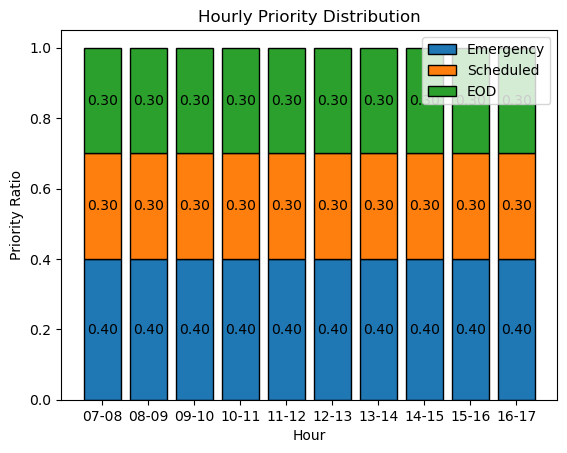

In [22]:
# Convert to numpy array
dist = np.array(PRIO_DIST)   # shape = (n_hours, 3)

# Build x-axis labels like '07-08', '08-09', ...
start_hour = prio_dist_input.start_hour
n_hours = prio_dist_input.n_hours
hours_lbl = [f"{start_hour + i:02d}-{start_hour + i + 1:02d}" for i in range(n_hours)]
x = np.arange(n_hours)      # numeric positions for bars

# Plot stacked bar chart
fig, ax = plt.subplots()
bottom = np.zeros(n_hours)  # Initialize the bottom of the bars
for idx, label in enumerate(PRIO_LST):
    ax.bar(x, dist[:, idx], label=label, bottom=bottom, edgecolor='black')
    bottom += dist[:, idx]  # Update the bottom for the next priority level

# Annotate each segment with its value
for i in range(n_hours):
    for j, value in enumerate(reversed(dist[i])):
        ax.text(i, bottom[i] - value / 2, f"{value:.2f}", ha='center', va='center')
        bottom[i] -= value

# Configure axes, ticks and legend
ax.set_xlabel('Hour')
ax.set_ylabel('Priority Ratio')
ax.set_title('Hourly Priority Distribution')
ax.set_xticks(x)
ax.set_xticklabels(hours_lbl)
ax.legend()

plt.show()

### Order Number Editor

In [23]:
class OrderNumberInput:

    def __init__(self, default=200, min_value=0):
        # Create the IntText input for total orders
        self.title = widgets.HTML(value="<h2 style='font-weight:bold;'>Number of Orders Input</h2>")
        self.input = widgets.IntText(
            value=default,
            min=min_value,
            step=10,
            description='Number of Orders:',
            style={'description_width': '120px'},
            layout=widgets.Layout(width='240px')
        )
        
        # Create a Save button
        self.save_button = widgets.Button(
            description='Save',
            button_style='success',
            layout=widgets.Layout(width='80px')
        )
        
        # Create an output area for showing saved value
        self.output = widgets.Output()
        
        # Attach callback to the Save button
        self.save_button.on_click(self._on_save)

        # Store saved value
        self.saved_value = default
    
    def _on_save(self, b):
        # Store the current input value
        global N_ORDERS
        self.saved_value = self.input.value
        N_ORDERS = self.saved_value
        with self.output:
            self.output.clear_output()
            print(f"Saved number of orders: {self.input.value}")
    
    def display(self):
        display(widgets.VBox([self.title, self.input, self.save_button]))
        display(self.output)

### Order Number Input

In [24]:
n_order_input = OrderNumberInput()
n_order_input.display()

Output()

In [25]:
N_ORDERS = n_order_input.saved_value
N_ORDERS

200

### Orders Generation Time

In [26]:
class OrderTime:
    def __init__(self, n_orders=None, order_dist=None):
        self.n_orders = n_orders if n_orders else N_ORDERS
        self.order_dist = order_dist if order_dist else ORDER_DIST
    
    def uniform_gen(self, n):
        times = np.random.uniform(0, 3600, size=n)
        return np.sort(times)
    
    def get_times(self):
        self.n_per_hour = np.random.multinomial(self.n_orders, self.order_dist)
        times = []
        for hr, count in enumerate(self.n_per_hour):
            if count > 0:
                times_hr = self.uniform_gen(count)
                times_hr = times_hr + hr * 3600
                times.extend(times_hr)
        return np.sort(times)

In [27]:
ORDER_TIMES = OrderTime().get_times()
ORDER_TIMES

array([   35.85240099,    93.346321  ,  2920.01059539,  3736.00514906,
        3834.84273235,  4468.93415153,  4754.95623083,  5472.34132435,
        6031.00165474,  6188.09426081,  6286.2320487 ,  6308.02213733,
        6514.05954636,  6553.28154582,  7244.31725798,  7311.23576506,
        7533.32592751,  7595.39393208,  7671.33950994,  8051.0215657 ,
        8592.27591206,  9001.6607885 ,  9202.97072201,  9365.44376271,
        9442.8069745 ,  9455.34906216,  9971.32336445, 10673.89610682,
       10803.71047767, 10861.98139711, 10899.52958825, 10900.38713657,
       10979.77907498, 11041.77400595, 11246.04658402, 11446.13999775,
       11870.50664768, 12063.20051242, 12096.82624245, 12153.62736303,
       12373.29179432, 12393.3885019 , 12557.04648513, 12599.40467425,
       12626.10862895, 12735.54657202, 12753.35343163, 13065.97420162,
       13352.863169  , 13390.95199267, 13463.0263237 , 13610.03533044,
       13674.47949451, 13687.29784814, 13798.3807104 , 13807.28462373,
      

# Process Definition

## Class Order, Delivery and ResourceUnit

In [28]:
# Define the Order class to represent an order in the simulation
@dataclass
class Order:
    id: int
    prio: str                   # Priority: 'Emergency' / 'Scheduled' / 'EOD'
    gen_at: float               # Generation time (seconds)
    distance: float             # Distance (meters)
    weight: float               # Weight (kg)
    win_start: Optional[float] = None  # Window start time (seconds)
    win_end: Optional[float] = None    # Window end time (seconds)
    is_vac: Optional[bool] = None      # Whether it is vaccine
    call_start: Optional[float] = None # Call start time (seconds)
    call_dur: Optional[float] = None   # Call duration (seconds)
    call_end: Optional[float] = None   # Call end time (seconds)
    call_op_id: Optional[int] = None   # Call operator ID
    complete: Optional[bool] = None    # Whether the order is delivered completely
    ontime: Optional[bool] = None      # Whether the order is delivered ontime

In [29]:
# Define the Delivery class to represent a delivery in the simulation
@dataclass
class Delivery:
    id: int
    order_id: int           # Associated Order ID
    prio: str               # Priority: 'Emergency' / 'Scheduled' / 'EOD'
    distance: float         # Distance (meters)
    win_start: Optional[float] = None       # Window start time (seconds)
    win_end: Optional[float] = None         # Window end time (seconds)
    is_vac: Optional[bool] = None           # Whether it is vaccine
    # Pick-up
    pick_start: Optional[float] = None
    pick_dur: Optional[float] = None
    pick_end: Optional[float] = None
    pick_op_id: Optional[int] = None        # Pick-up Operator ID
    # Assembly
    assm_start: Optional[float] = None
    assm_dur: Optional[float] = None
    assm_end: Optional[float] = None
    assm_op_id: Optional[int] = None        # Assemble Operator ID
    # Launch (w/ Launcher)
    lnch_start: Optional[float] = None
    lnch_dur: Optional[float] = None
    lnch_end: Optional[float] = None
    lnchr_id: Optional[int] = None          # Launcher ID
    # Flight
    flight_start: Optional[float] = None    # Takeoff time
    outbound_dur: Optional[float] = None    # Outbound duration
    outbound_speed: Optional[float] = None  # Outbound speed
    arrive_time: Optional[float] = None     # Arrival time at destination
    inbound_dur: Optional[float] = None     # Inbound duration
    inbound_speed: Optional[float] = None   # Inbound speed
    flight_end: Optional[float] = None      # Return time
    # Recovery
    reco_start: Optional[float] = None
    reco_dur: Optional[float] = None
    reco_end: Optional[float] = None
    reco_op_id: Optional[int] = None        # Recover Operator ID
    # Drone & Battery
    zip_id: Optional[int] = None            # Drone ID
    batt_id: Optional[int] = None           # Battery ID
    chrgr_id: Optional[int] = None          # Charger ID
    chrg_start: Optional[float] = None      # Charging start time
    chrg_dur: Optional[float] = None        # Charging duration
    chrg_end: Optional[float] = None        # Charging end time
    # Result
    ontime: Optional[bool] = None           # Whether the delivery is sent ontime

In [30]:
class ResourceUnit:
    def __init__(self, id: int):
        self.id = id

## Useful Functions

In [31]:
# Define the function of Truncated Normal Generator
# to generate a random value based on normal distribution constrained by a minimum value

def tn_gen(avg: float, std: float, lower: float = 0.0, upper: float = np.inf) -> float:
    a, b = (lower - avg) / std, (upper - avg) / std
    return stats.truncnorm.rvs(a, b, loc=avg, scale=std)

In [32]:
# Define the function to change seconds into readable version
class TimeTick:
    def __init__(self, t: float):
        self.t = t
        st = time.gmtime(t)
        # day number
        self.dd: int = st.tm_yday
        # h/m/s
        self.hh: int = st.tm_hour
        self.mm: int = st.tm_min
        self.ss: int = st.tm_sec
        self.daytag  = f"Day {self.dd}, {self.hh:02d}:{self.mm:02d}:{self.ss:02d}"
        self.timetag = f"{self.hh:02d}:{self.mm:02d}:{self.ss:02d}"
        self.timetag_sim = f"{self.hh+HR_STT:02d}:{self.mm:02d}:{self.ss:02d}"
        self.durtag  = f"{self.mm:02d}m {self.ss:02d}s" if self.hh == 0 else f"{self.hh:02d}h {self.mm:02d}m {self.ss:02d}s"

In [33]:
# Define the function to change dataframe into readable version
def df_str(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()
    for col in df.columns:
        if 'Start' in col or 'End' in col or col == 'GenerateTime':
            df_new[col] = df[col].apply(lambda t: TimeTick(t).timetag_sim if not pd.isna(t) else np.nan)
        elif 'Duration' in col or 'Wait' in col:
            df_new[col] = df[col].apply(lambda x: TimeTick(x).durtag)
        elif col in ['Distance(m)', 'Weight(kg)'] or 'Speed' in col:
            df_new[col] = df[col].apply(lambda x: round(x, 2))
        elif 'ID' in col:
            df_new[col] = df[col].apply(lambda x: int(x) if x is not None else None)
    return df_new

## Main Process

### Orders Call-in

In [34]:
class Call:

    # Call class to handle call operations.
    
    def __init__(
            self, env, 
            t_sim=None, n_call_ops=None, t_call_avg=None, t_call_std=None
            ):
        self.env = env
        attr_lst = [('t_sim',       T_SIM), 
                    ('n_call_ops',  N_CALL_OPS),
                    ('t_call_avg',  T_CALL_AVG),
                    ('t_call_std',  T_CALL_STD)
                    ]
        for attr, default in attr_lst:
            setattr(self, attr, locals()[attr] if locals()[attr] else default)
        self.call_ops = simpy.Store(env)
        for i in range(self.n_call_ops):
            self.call_ops.put(ResourceUnit(i))
        self.orders = []                  # Main list: each order's info

    def call_process(self, order):
        # SimPy process for handling a single call.
        call_op = yield self.call_ops.get()
        order.call_op_id  = call_op.id
        if self.env.now >= self.t_sim:
            return
        order.call_start = self.env.now
        order.call_dur = tn_gen(self.t_call_avg, self.t_call_std)
        yield self.env.timeout(order.call_dur)
        order.call_end = self.env.now
        self.orders.append(order)
        yield self.call_ops.put(call_op)

### Deliveries Dispatch-out

In [35]:
class Dispatch:

    def __init__(self, env):

        self.env = env

        # initialize resource stores
        resources = {
            'zips':     N_ZIPS,
            'batts':    N_BATTS,
            'pick_ops': N_PICK_OPS,
            'assm_ops': N_ASSM_OPS,
            'lnchrs':   N_LNCHRS,
            'reco_ops': N_RECO_OPS,
            'chrgrs':   N_CHRGRS
        }

        for name, count in resources.items():
            store = simpy.Store(env)
            setattr(self, name, store)
            for i in range(count):
                store.put(ResourceUnit(i))

        # Main list: each delivery's info
        self.deliveries = []
        self._delivery_id = 0

        # Queue lists
        self.queue_pick = []
        self.queue_flight = []

        # Start the queues
        self.env.process(self._queue_pick_loop())
        self.env.process(self._queue_flight_loop())

    def dispatch_start(self, order: Order):
        # After order call is completed, put it into the dispatch queue
        n_deliveries = int(order.weight / W_CAP) + 1
        for i in range(n_deliveries):
            delivery = Delivery(
                id=self._delivery_id, 
                order_id = order.id, 
                prio = order.prio,
                distance = order.distance,
                win_start = order.win_start,
                win_end = order.win_end,
                is_vac = order.is_vac
                )
            self.queue_pick.append(delivery)
            self._delivery_id += 1

    def delivery_sort_key(self, d: Delivery):
        """
        General sorting function, returns a (group, subkey) tuple:
        group:
          0 = Emergency
          1 = Scheduled Ready (ETA >= window_start)
          2 = EOD
          3 = Scheduled Unready (ETA < window_start)
        subkey:
          - group 0: d.id (FIFO)
          - group 1: slack = window_end - ETA (the smaller the more urgent)
          - group 2: d.id (FIFO)
          - group 3: window_start (the earlier the former)
        """
        prio = d.prio
        current = self.env.now
        if prio == PRIO_LST[0]:     # 'Emergency'
            grp = 0
            sub = d.id
        elif prio == PRIO_LST[1]:   #'Scheduled'
            eta = current + d.distance / V_ZIP_AVG
            if eta >= d.win_start:
                grp = 1
                sub = d.win_end - eta
            else:
                grp = 3
                sub = d.win_start
        else:                       # EOD
            grp = 2
            sub = d.id

        return (grp, sub)

    def _queue_pick_loop(self):
        # queue reorder before pick-up
        while self.env.now <= T_SIM:
            if self.pick_ops.items and self.queue_pick:
                self.queue_pick.sort(key=self.delivery_sort_key)
                if self.delivery_sort_key(self.queue_pick[0])[0] != 3:
                    next_d = self.queue_pick.pop(0)
                    self.env.process(self.pick_process(next_d))
            yield self.env.timeout(1)

    def _queue_flight_loop(self):
        # queue reorder before assembly
        while self.env.now <= T_SIM:
            self.queue_flight.sort(key=self.delivery_sort_key)
            if self.zips.items and self.batts.items and self.queue_flight:
                if self.delivery_sort_key(self.queue_flight[0])[0] == 0:
                    next_d = self.queue_flight.pop(0)
                    self.env.process(self.flight_process(next_d))
                elif self.delivery_sort_key(self.queue_flight[0])[0] != 3:
                    # Only when there are n drones / batteries reserved for emergency
                    # will the regular deliveries be processed
                    if (len(self.zips.items) > N_ZIPS_EM) and (len(self.batts.items) > N_BATTS_EM):
                        next_d = self.queue_flight.pop(0)
                        self.env.process(self.flight_process(next_d))
            yield self.env.timeout(1)

    def pick_process(self, delivery: Delivery):
        # SimPy process to handle Pick-up operation

        # 1) Pick-Up
        pick_op                 = yield self.pick_ops.get()
        if self.env.now >= T_SIM:
            self.deliveries.append(delivery)
            return
        delivery.pick_start     = self.env.now
        # differnet pick-up time for vaccines
        if delivery.is_vac:
            delivery.pick_dur   = tn_gen(T_PICK_AVG_VAC, T_PICK_STD_VAC)
        else:
            delivery.pick_dur   = tn_gen(T_PICK_AVG_NON, T_PICK_STD_NON)
        yield self.env.timeout(delivery.pick_dur)
        delivery.pick_op_id     = pick_op.id
        delivery.pick_end       = self.env.now
        yield self.pick_ops.put(pick_op)

        self.queue_flight.append(delivery)

    def flight_process(self, delivery: Delivery):
        # SimPy process to handle the operations after Pick-up

        # 2) Get a Drone & Battery from Store
        zip     = yield self.zips.get()
        batt    = yield self.batts.get()
        delivery.zip_id  = zip.id
        delivery.batt_id = batt.id

        # 3) Assembly
        assm_op             = yield self.assm_ops.get()
        if self.env.now >= T_SIM:
            self.deliveries.append(delivery)
            return
        delivery.assm_start = self.env.now
        delivery.assm_dur   = tn_gen(T_ASSM_AVG, T_ASSM_STD)
        yield self.env.timeout(delivery.assm_dur)
        delivery.assm_op_id = assm_op.id
        delivery.assm_end   = self.env.now

        # 4) Launch
        lnchr               = yield self.lnchrs.get()
        delivery.lnch_start = self.env.now
        delivery.lnch_dur   = tn_gen(T_LNCH_AVG, T_LNCH_STD)
        yield self.env.timeout(delivery.lnch_dur)
        delivery.lnchr_id   = lnchr.id
        delivery.lnch_end   = self.env.now
        yield self.lnchrs.put(lnchr)
        yield self.assm_ops.put(assm_op)

        # 5) Flight
        delivery.flight_start   = self.env.now
        # 5.1) Outbound
        delivery.outbound_speed = tn_gen(V_ZIP_AVG, V_ZIP_STD, V_ZIP_MIN)
        delivery.outbound_dur   = delivery.distance * 1000 / delivery.outbound_speed
        yield self.env.timeout(delivery.outbound_dur)
        delivery.arrive_time    = self.env.now
        # 5.2) Inbound
        delivery.inbound_speed  = tn_gen(V_ZIP_AVG, V_ZIP_STD, V_ZIP_MIN)
        delivery.inbound_dur    = delivery.distance * 1000 / delivery.inbound_speed
        yield self.env.timeout(delivery.inbound_dur)
        delivery.flight_end     = self.env.now

        # 6) Recovery
        reco_op             = yield self.reco_ops.get()
        delivery.reco_start = self.env.now
        delivery.reco_dur   = tn_gen(T_RECO_AVG, T_RECO_STD)
        yield self.env.timeout(delivery.reco_dur)
        delivery.reco_op_id = reco_op.id
        delivery.reco_end   = self.env.now
        yield self.reco_ops.put(reco_op)

        # 7) Release Drone
        yield self.zips.put(zip)

        # 8) Charging
        chrgr   = yield self.chrgrs.get()
        delivery.chrg_start = self.env.now
        delivery.chrg_dur   = tn_gen(T_CHRG_AVG, T_CHRG_STD)
        yield self.env.timeout(delivery.chrg_dur)
        delivery.chrgr_id   = chrgr.id
        delivery.chrg_end   = self.env.now
        yield self.chrgrs.put(chrgr)

        # 9) Release Battery
        yield self.batts.put(batt)

        self.deliveries.append(delivery)

### Aggregated

In [36]:
def order_lifecycle(env, order, caller, dispatcher):
    yield env.process(caller.call_process(order))
    dispatcher.dispatch_start(order)

In [37]:
def order_process(env, caller: Call, dispatcher: Dispatch):
    # SimPy process to generate incoming orders.
    
    order_id = 0  # Order ID counter

    for t in ORDER_TIMES:

        yield env.timeout(t - env.now)
        current = env.now

        # 1. Generate a new order with a unique ID, priority, distance, and weight.
        prio_probs = PRIO_DIST[TimeTick(current).hh]   # e.g. [0.6, 0.3, 0.1]
        prio = np.random.choice(PRIO_LST, p=prio_probs)
        distance = tn_gen(D_AVG, D_STD, D_MIN)
        weight = tn_gen(W_AVG, W_STD, W_MIN)
        order = Order(
            id=order_id,
            prio=prio,
            gen_at=current,
            distance=distance,
            weight=weight
        )

        # 2. Generate window_start as a random half-hour or full-hour point greater than the current time.
        if order.prio == PRIO_LST[1]:   # Scheduled
            win_start_max = HRS_GEN * 60 * 60
            order.win_start = ((tn_gen(current + WIN_LAG_AVG, WIN_LAG_STD, 0, win_start_max) // WIN_SLOT) + 1) * WIN_SLOT
            order.win_end = order.win_start + WIN_LEN

        # 3. Decide whether the order is a vaccine.
        p_vac = P_VAC
        if order.distance >= D_CC:      # Cold-Chain
            p_vac *= Q_VAC_CC
        if order.prio == PRIO_LST[0]:   # Emergency
            p_vac *= Q_VAC_EM
        order.is_vac = np.random.rand() < p_vac

        # 4. Start the process
        env.process(order_lifecycle(env, order, caller, dispatcher))

        order_id += 1

### Whole Simulation

In [38]:
def sim_run(n_orders=None):
    if n_orders:
        global N_ORDERS, ORDER_TIMES
        N_ORDERS = n_orders
    ORDER_TIMES = OrderTime().get_times()
    env = simpy.Environment()
    caller     = Call(env)
    dispatcher = Dispatch(env)
    env.process(order_process(env, caller, dispatcher))
    env.run(until=T_SIM)
    return caller, dispatcher

### Outcome Conversion

In [39]:
def orders2df(caller: Call):
    order_df = pd.DataFrame([{
        'ID':            o.id,
        'Priority':      o.prio,
        'GenerateTime':  o.gen_at,
        'Distance(km)':   o.distance,
        'Weight(kg)':    o.weight,
        'CallStart':     o.call_start,
        'CallDuration':  o.call_dur,
        'CallEnd':       o.call_end,
        'CallOpID':      o.call_op_id,
        'WindowStart':   o.win_start,
        'WindowEnd':     o.win_end,
        'IsVaccine':     o.is_vac
    } for o in caller.orders]).set_index('ID')
    return order_df

In [40]:
def deliveries2df(dispatcher: Dispatch):
    delivery_df = pd.DataFrame([{
        'ID': d.id,
        'OrderID': d.order_id,
        'Priority': d.prio,
        'Distance(km)': d.distance,
        'WindowStart': d.win_start,
        'WindowEnd': d.win_end,
        'IsVaccine': d.is_vac,
        'PickStart': d.pick_start,
        'PickDuration': d.pick_dur,
        'PickEnd': d.pick_end,
        'PickOpID': d.pick_op_id,
        'AssmStart': d.assm_start,
        'AssmDuration': d.assm_dur,
        'AssmEnd': d.assm_end,
        'AssmOpID': d.assm_op_id,
        'LnchStart': d.lnch_start,
        'LnchDuration': d.lnch_dur,
        'LnchEnd': d.lnch_end,
        'LnchrID': d.lnchr_id,
        'FlightStart': d.flight_start,
        'OutboundDuration': d.outbound_dur,
        'ArriveTime': d.arrive_time,
        'InboundDuration': d.inbound_dur,
        'FlightEnd': d.flight_end,
        'RecoStart': d.reco_start,
        'RecoDuration': d.reco_dur,
        'RecoEnd': d.reco_end,
        'RecoOpID': d.reco_op_id,
        'ZipID': d.zip_id,
        'BattID': d.batt_id,
        'ChrgrID': d.chrgr_id,
        'ChrgStart': d.chrg_start,
        'ChrgDuration': d.chrg_dur,
        'ChrgEnd': d.chrg_end,
        'SpeedOutbound(m/s)': d.outbound_speed,
        'SpeedInbound(m/s)': d.inbound_speed
    } for d in dispatcher.deliveries]).set_index('ID')
    return delivery_df

# Run the Simulation

## Run

In [41]:
caller, dispatcher = sim_run()

## Result Dataframe

In [42]:
df_str(orders2df(caller))

,Priority,GenerateTime,Distance(km),Weight(kg),CallStart,CallDuration,CallEnd,CallOpID,WindowStart,WindowEnd,IsVaccine
ID,,,,,,,,,,,
0,EOD,07:05:27,33.588692,1.03,07:05:27,05m 35s,07:11:02,0,NaN,NaN,False
1,EOD,07:13:10,54.254179,1.13,07:13:10,05m 07s,07:18:18,1,NaN,NaN,False
2,Scheduled,07:13:45,13.306319,1.04,07:13:45,07m 53s,07:21:39,2,14:30:00,16:30:00,False
3,Emergency,07:24:42,57.356708,1.06,07:24:42,05m 52s,07:30:35,0,NaN,NaN,True
4,EOD,07:47:04,61.269818,1.05,07:47:04,03m 29s,07:50:34,1,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
196,Scheduled,16:25:01,70.567973,0.88,16:25:01,05m 34s,16:30:35,0,16:30:00,18:30:00,False
195,EOD,16:23:03,36.845221,1.00,16:23:03,07m 56s,16:30:59,1,NaN,NaN,False
197,Emergency,16:33:06,61.531549,0.92,16:33:06,04m 30s,16:37:36,2,NaN,NaN,True


In [43]:
df_str(deliveries2df(dispatcher))

,OrderID,Priority,Distance(km),WindowStart,WindowEnd,IsVaccine,PickStart,PickDuration,PickEnd,PickOpID,...,RecoEnd,RecoOpID,ZipID,BattID,ChrgrID,ChrgStart,ChrgDuration,ChrgEnd,SpeedOutbound(m/s),SpeedInbound(m/s)
ID,,,,,,,,,,,,,,,,,,,,,
0,0,EOD,33.588692,NaN,NaN,False,07:11:03,05m 24s,07:16:27,0,...,08:03:54,0,0,0,0,08:03:54,26m 27s,08:30:22,20.86,35.25
1,1,EOD,54.254179,NaN,NaN,False,07:18:19,04m 52s,07:23:11,1,...,08:53:11,0,1,1,2,08:53:11,15m 08s,09:08:20,22.30,20.36
3,3,Emergency,57.356708,NaN,NaN,True,07:30:36,09m 13s,07:39:49,2,...,08:55:07,0,2,2,3,08:55:07,20m 30s,09:15:38,26.53,27.70
8,7,Emergency,18.825395,NaN,NaN,False,08:04:40,04m 56s,08:09:36,0,...,08:47:12,0,6,6,1,08:47:12,43m 00s,09:30:13,26.03,24.39
4,4,EOD,61.269818,NaN,NaN,False,07:50:35,04m 25s,07:55:00,0,...,09:22:05,0,3,3,5,09:22:05,22m 11s,09:44:17,24.25,24.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,187,Emergency,89.969233,NaN,NaN,True,15:53:50,10m 06s,16:03:56,0,...,18:15:52,0,5,25,3,18:15:52,36m 06s,18:51:58,26.02,23.57
204,194,Emergency,65.356589,NaN,NaN,False,16:03:57,04m 15s,16:08:12,0,...,18:17:23,0,10,10,11,18:17:23,37m 19s,18:54:43,15.08,23.54
33,31,Scheduled,78.548909,14:30:00,16:30:00,False,14:33:48,04m 22s,14:38:10,2,...,18:35:30,0,8,3,19,18:35:30,19m 23s,18:54:53,26.27,19.86


## Performance Analysis

### Waiting Time

In [44]:
def get_wait_summary(caller: Call, dispatcher: Dispatch):
    order_df = orders2df(caller)
    delivery_df = deliveries2df(dispatcher)
    # Basic statistics
    def get_prio_dist(df):
        max_priority_len = max(len(priority) for priority in df['Priority'].unique())
        for priority, count in df['Priority'].value_counts().items():
            print(f"  {priority:<{max_priority_len}}  {count}")
    # orders generated
    n_orders = len(order_df)
    print(f"Initially, {n_orders} Orders Generated, with Priority Distribution:")
    get_prio_dist(order_df)
    print()
    # orders overweight
    orders_df_overweight = order_df[order_df['Weight(kg)'] > W_CAP]
    n_orders_overweight = len(orders_df_overweight)
    n_deliveries_overweight = orders_df_overweight['Weight(kg)'].apply(lambda w: int(w // W_CAP + 1)).sum()
    n_deliveries_needed = n_orders + n_deliveries_overweight - n_orders_overweight
    n_deliveries_needed_per_priority = order_df.groupby('Priority')['Weight(kg)'].apply(lambda w: w.apply(lambda x: int(x // W_CAP + 1)).sum())
    print(f'Where {n_orders_overweight} orders have weight > {W_CAP}:')
    print(orders_df_overweight[['Weight(kg)', 'Priority']])
    print(f'Which were divided into {n_deliveries_overweight} deliveries in total.')
    print()
    # deliveries needed
    print(f'That means {n_deliveries_needed} Deliveries Needed, with Priority Distribution:')
    for priority, count in n_deliveries_needed_per_priority.sort_values(ascending=False).items():
        print(f"  {priority:<{max(len(p) for p in PRIO_LST)}}  {count}")
    print()
    # deliveries completed
    n_deliveries = len(delivery_df)
    print(f"Eventually, {n_deliveries} Deliveries Completed, with Priority Distribution: ")
    get_prio_dist(delivery_df)

    # Stage waiting time statistics
    stage_wait_data = {
        'Call': [],
        'Pick-up': [],
        'Assembly': [],
        'Launch': [],
        'Flight': [],
        'Recovery': [],
        'Charging': []
    }

    stage_wait_data['Call'] = (order_df['CallStart'] - order_df['GenerateTime']).tolist()

    for d in dispatcher.deliveries:
        # Calculate Pick-up waiting time based on order priority
        order = next((o for o in caller.orders if o.id == d.order_id), None)
        if d.pick_start:
            if d.prio == PRIO_LST[1]:  # Scheduled
                # For scheduled: pick_start - win_start
                if d.win_start:
                    wait_time = max(0, d.pick_start - d.win_start)
                    stage_wait_data['Pick-up'].append(wait_time)
            else:  # Emergency & EOD
                # For Emergency & EOD: pick_start - call_end
                if order and order.call_end:
                    wait_time = max(0, d.pick_start - order.call_end)
                    stage_wait_data['Pick-up'].append(wait_time)

        stages = [
            ('Assembly', 'assm_start', 'pick_end'),
            ('Launch', 'lnch_start', 'assm_end'),
            # Flight shall not wait as no extra resources needed
            # ('Flight', 'flight_start', 'lnch_end'),
            ('Recovery', 'reco_start', 'flight_end'),
            ('Charging', 'chrg_start', 'reco_end')
        ]

        for stage, start_attr, end_attr in stages:
            start_time = getattr(d, start_attr, None)
            end_time = getattr(d, end_attr, None)
            if start_time and end_time:
                wait_time = max(0, start_time - end_time)
                stage_wait_data[stage].append(wait_time)

    # Display stage waiting time statistics (without Total Instances column)
    print("\nStage Waiting Time Statistics:")
    summary = []
    for stage, times in stage_wait_data.items():
        if times:
            summary.append({
            'Stage': stage,
            'Avg Wait Time': TimeTick(np.mean(times)).durtag,
            'Med Wait Time': TimeTick(np.median(times)).durtag,
            'Max Wait Time': TimeTick(max(times)).durtag,
            'Min Wait Time': TimeTick(min(times)).durtag
            })

    summary_df = pd.DataFrame(summary).set_index('Stage')
    print(summary_df)

    

    # For each stage, generate detailed waiting time statistics
    for stage, times in stage_wait_data.items():
        if times:
            n_wait = sum(1 for t in times if t > 1)
            summary_stage = summary_df.loc[stage]
            print(f"\n{'-'*30} {stage} Waiting Time {'-'*30}")
            print(f"Orders that waited:           {n_wait} ({n_wait/n_deliveries*100:.1f}%)")
            print(f"Average waiting time:         {summary_stage['Avg Wait Time']}")
            print(f"Median waiting time:          {summary_stage['Med Wait Time']}")
            print(f"Max waiting time:             {summary_stage['Max Wait Time']}")
            print(f"Min waiting time:             {summary_stage['Min Wait Time']}")

            # Percentile statistics
            pct_75 = TimeTick(np.percentile(times, 75)).durtag
            pct_90 = TimeTick(np.percentile(times, 90)).durtag
            print(f"75% of orders waited less than: {pct_75}")
            print(f"90% of orders waited less than: {pct_90}")

            # Plot waiting time distribution
            plt.title(f"Distribution of {stage} Waiting Times")
            sns.histplot(times, bins=20, kde=True, edgecolor='black')
            plt.xlabel("Time (Seconds)")
            plt.grid(True)
            plt.xlim(left=0)
            plt.show()
    

Initially, 200 Orders Generated, with Priority Distribution:
  Emergency  76
  EOD        66
  Scheduled  58

Where 11 orders have weight > 1.2:
     Weight(kg)   Priority
ID                        
6      1.209621  Emergency
11     1.210134        EOD
13     1.206587  Scheduled
38     1.213890  Scheduled
43     1.211164  Emergency
63     1.208020  Scheduled
110    1.279643  Emergency
122    1.207802  Scheduled
126    1.244518  Emergency
144    1.243564  Emergency
160    1.276614  Emergency
Which were divided into 22 deliveries in total.

That means 211 Deliveries Needed, with Priority Distribution:
  Emergency  82
  EOD        67
  Scheduled  62

Eventually, 113 Deliveries Completed, with Priority Distribution: 
  Emergency  80
  Scheduled  22
  EOD        11

Stage Waiting Time Statistics:
         Avg Wait Time Med Wait Time Max Wait Time Min Wait Time
Stage                                                           
Call           03m 02s       02m 22s       15m 35s       00m 00s
Pi

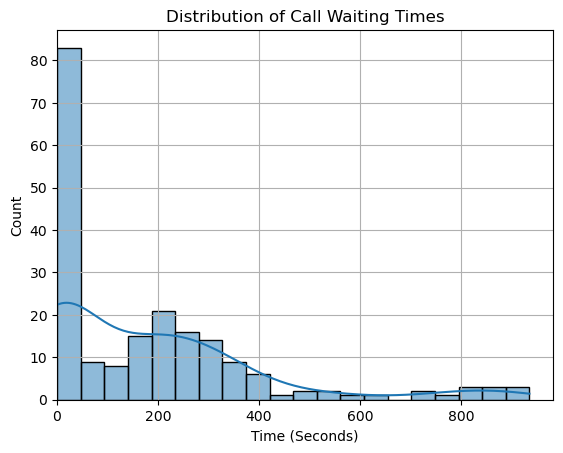


------------------------------ Pick-up Waiting Time ------------------------------
Orders that waited:           84 (74.3%)
Average waiting time:         04m 33s
Median waiting time:          01m 19s
Max waiting time:             01h 19m 39s
Min waiting time:             00m 00s
75% of orders waited less than: 04m 27s
90% of orders waited less than: 08m 34s


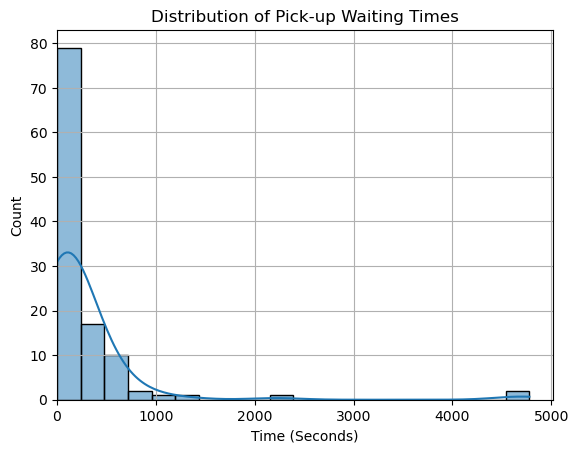


------------------------------ Assembly Waiting Time ------------------------------
Orders that waited:           89 (78.8%)
Average waiting time:         29m 06s
Median waiting time:          09m 22s
Max waiting time:             03h 25m 29s
Min waiting time:             00m 00s
75% of orders waited less than: 32m 41s
90% of orders waited less than: 01h 56m 30s


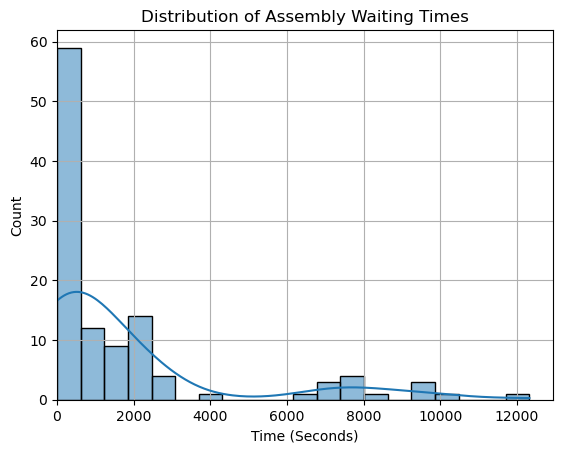


------------------------------ Launch Waiting Time ------------------------------
Orders that waited:           0 (0.0%)
Average waiting time:         00m 00s
Median waiting time:          00m 00s
Max waiting time:             00m 00s
Min waiting time:             00m 00s
75% of orders waited less than: 00m 00s
90% of orders waited less than: 00m 00s


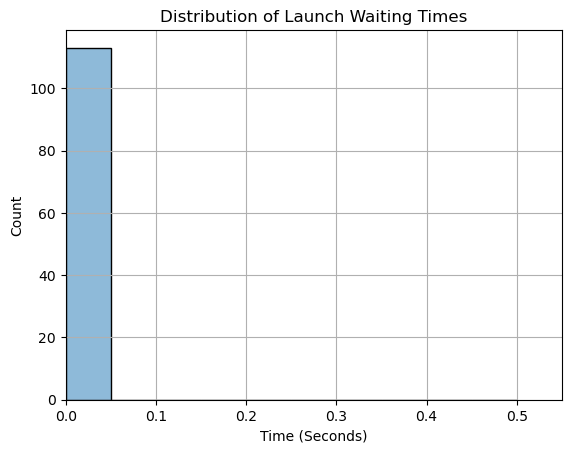


------------------------------ Recovery Waiting Time ------------------------------
Orders that waited:           33 (29.2%)
Average waiting time:         00m 25s
Median waiting time:          00m 00s
Max waiting time:             03m 30s
Min waiting time:             00m 00s
75% of orders waited less than: 00m 32s
90% of orders waited less than: 01m 30s


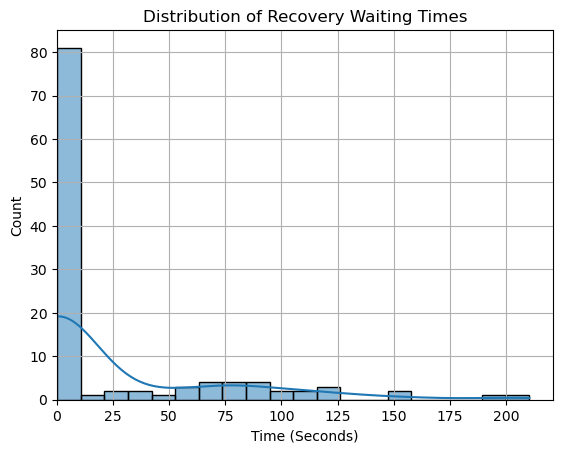


------------------------------ Charging Waiting Time ------------------------------
Orders that waited:           0 (0.0%)
Average waiting time:         00m 00s
Median waiting time:          00m 00s
Max waiting time:             00m 00s
Min waiting time:             00m 00s
75% of orders waited less than: 00m 00s
90% of orders waited less than: 00m 00s


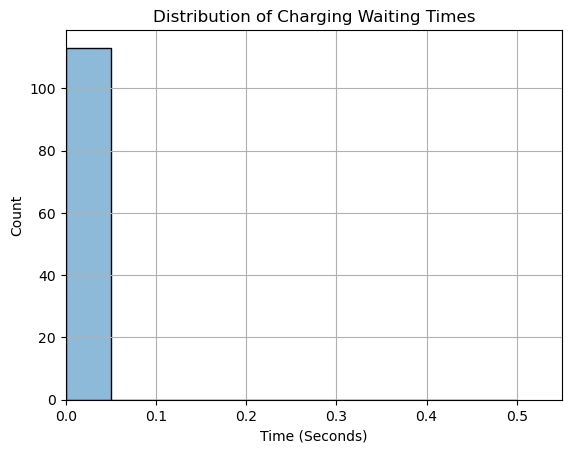

In [45]:
get_wait_summary(caller, dispatcher)

### On-Time Rate

In [46]:
def get_ontime_summary(caller: Call, dispatcher: Dispatch):

    d_times_em = []
    d_times_sch = []
    d_times_eod = []
    d_times_data = {
        PRIO_LST[0]: d_times_em,
        PRIO_LST[1]: d_times_sch,
        PRIO_LST[2]: d_times_eod,
    }

    for o in caller.orders:
        n_o_ds_needed = int(o.weight // W_CAP + 1)
        o_ds_completed = [d for d in dispatcher.deliveries if o.id == d.order_id]
        o.complete = len(o_ds_completed) == n_o_ds_needed
        for d in o_ds_completed:
            d_time = d.arrive_time - o.gen_at
            if d.prio == PRIO_LST[0]:   # Emergency
                # For Emergency: arrive in 2 hours
                d_times_em.append(d_time)
                d.ontime = d_time <= 2 * 60 * 60
            elif d.prio == PRIO_LST[1]: # Scheduled
                # For scheduled: arrive_time <= win_end
                d_times_sch.append(d.arrive_time - d.win_start)
                d.ontime = d.arrive_time <= d.win_end
            else:                       # EOD
                # For EOD: arrive in 6 hours
                d_times_eod.append(d_time)
                d.ontime = d_time <= 6 * 60 * 60
        o.ontime = o.complete and all(d.ontime for d in o_ds_completed)

    # For each priority, generate detailed waiting time statistics
    for prio, times in d_times_data.items():
        if times:
            print(f"\n{'-'*30} {prio} Delivery Time {'-'*30}")
            print(f"Average delivery time:         {TimeTick(np.mean(times)).durtag}")
            print(f"Median delivery time:          {TimeTick(np.median(times)).durtag}")
            print(f"Max delivery time:             {TimeTick(max(times)).durtag}")
            print(f"Min delivery time:             {TimeTick(np.min(times)).durtag}")

            # Percentile statistics
            pct_75 = TimeTick(np.percentile(times, 75)).durtag
            pct_90 = TimeTick(np.percentile(times, 90)).durtag
            print(f"75% of orders arrived in less than: {pct_75}")
            print(f"90% of orders arrived in less than: {pct_90}")

            # Plot waiting time distribution
            plt.title(f"Distribution of {prio} Delivery Times")
            sns.histplot(times, bins=20, kde=True, edgecolor='black')
            plt.xlabel("Time (Seconds)")
            plt.grid(True)
            plt.xlim(left=0)
            plt.show()

    df_orders = pd.DataFrame([o.__dict__ for o in caller.orders])
    df_deliveries = pd.DataFrame([d.__dict__ for d in dispatcher.deliveries])

    n_orders = len(df_orders)
    n_deliveries = len(df_deliveries)
    n_o_complete = df_orders['complete'].sum()
    n_o_ontime = df_orders['ontime'].sum()
    n_d_ontime = df_deliveries['ontime'].sum()
    o_complete_ratio = n_o_complete / n_orders
    o_ontime_ratio = n_o_ontime / n_orders
    d_ontime_ratio = n_d_ontime / n_deliveries
    print(f"Total complete orders:    \t {n_o_complete}/{n_orders}   \t ({o_complete_ratio:.2%})")
    print(f"Total on-time orders:     \t {n_o_ontime}/{n_o_complete} \t ({o_ontime_ratio:.2%})")
    print(f"Total on-time deliveries: \t {n_d_ontime}/{n_deliveries} \t ({d_ontime_ratio:.2%})")
    print()

    n_o_prio = df_orders['prio'].value_counts().reindex(PRIO_LST, fill_value=0)
    n_o_complete_prio = (
        df_orders[df_orders['complete']]
        .groupby('prio')
        .size()
        .reindex(PRIO_LST, fill_value=0)
    )
    n_o_ontime_prio = (
        df_orders[df_orders['ontime']]
        .groupby('prio')
        .size()
        .reindex(PRIO_LST, fill_value=0)
    )
    n_d_prio = df_deliveries['prio'].value_counts().reindex(PRIO_LST, fill_value=0)
    n_d_ontime_prio = (
        df_deliveries[df_deliveries['ontime']]
        .groupby('prio')
        .size()
        .reindex(PRIO_LST, fill_value=0)
    )

    for data, label in zip(
        [(n_o_complete_prio, n_o_prio),
         (n_o_ontime_prio, n_o_complete_prio), 
         (n_d_ontime_prio, n_d_prio)
         ],
        ['Orders Completed', 'Orders On-time', 'Deliveries On-time']
    ):
        for prio in PRIO_LST:
            ratio = data[0][prio] / data[1][prio] if data[1][prio] > 0 else 0
            print(f"{label} - {prio:<{max(len(p) for p in PRIO_LST)}} \t {data[0][prio]}/{data[1][prio]} \t ({ratio:.2%})")
        print()
    
    import matplotlib.colors as mcolors  # needed for RGBA conversion

    # Add a column for the hour of generation
    df_orders['Hour'] = df_orders['gen_at'].apply(lambda t: TimeTick(t).hh)

    # Group by hour and priority, count on-time, late, and failed orders
    df_orders['Status'] = df_orders.apply(
        lambda row: 'On-time' if row['ontime'] else ('Late' if row['complete'] else 'Failed'), axis=1
    )
    grouped = df_orders.groupby(['Hour', 'prio', 'Status']).size().unstack(fill_value=0)

    # Prepare data for plotting
    hours = sorted(df_orders['Hour'].unique())
    ontime_data = []
    late_data = []
    failed_data = []

    for prio in PRIO_LST:
        sub_group = grouped.xs(prio, level='prio')
        ser_on = sub_group['On-time'] if 'On-time' in sub_group.columns else pd.Series(0, index=hours)
        ser_late = sub_group['Late'] if 'Late' in sub_group.columns else pd.Series(0, index=hours)
        ser_failed = sub_group['Failed'] if 'Failed' in sub_group.columns else pd.Series(0, index=hours)
        ser_on = ser_on.reindex(hours, fill_value=0)
        ser_late = ser_late.reindex(hours, fill_value=0)
        ser_failed = ser_failed.reindex(hours, fill_value=0)
        ontime_data.append(ser_on.values)
        late_data.append(ser_late.values)
        failed_data.append(ser_failed.values)

    # Define base colors for each priority and alphas for statuses
    base_colors = {'Emergency': 'orange', 'Scheduled': 'green', 'EOD': 'blue'}
    alphas = {'On-time': 1.0, 'Late': 0.6, 'Failed': 0.3}

    # Plot stacked bar chart
    x = np.arange(len(hours))  # x-axis positions
    width = 0.8  # Bar width
    bottom = np.zeros(len(hours))  # Start bottom from 0

    fig, ax = plt.subplots(figsize=(10, 8))
    for idx, prio in enumerate(PRIO_LST):
        base_color = base_colors[prio]
        # Plot Failed orders with lightest shade
        color_failed = mcolors.to_rgba(base_color, alpha=alphas['Failed'])
        ax.bar(x, failed_data[idx], width, bottom=bottom, edgecolor='black',
               color=color_failed, label=f"{prio} Failed")
        bottom += failed_data[idx]
        # Plot Late orders with medium shade
        color_late = mcolors.to_rgba(base_color, alpha=alphas['Late'])
        ax.bar(x, late_data[idx], width, bottom=bottom, edgecolor='black',
               color=color_late, label=f"{prio} Late")
        bottom += late_data[idx]
        # Plot On-time orders with darkest shade
        color_ontime = mcolors.to_rgba(base_color, alpha=alphas['On-time'])
        ax.bar(x, ontime_data[idx], width, bottom=bottom, edgecolor='black',
               color=color_ontime, label=f"{prio} On-time")
        bottom += ontime_data[idx]

    # Configure axes, ticks, and legend
    ax.set_xlabel('Hour of Generation')
    ax.set_ylabel('Number of Orders')
    ax.set_title('Order Status by Priority and Hour')
    ax.set_xticks(x)
    ax.set_xticklabels(hours_lbl)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

    plt.show()
    


------------------------------ Emergency Delivery Time ------------------------------
Average delivery time:         01h 15m 15s
Median delivery time:          01h 18m 07s
Max delivery time:             02h 08m 16s
Min delivery time:             23m 51s
75% of orders arrived in less than: 01h 35m 04s
90% of orders arrived in less than: 01h 40m 42s


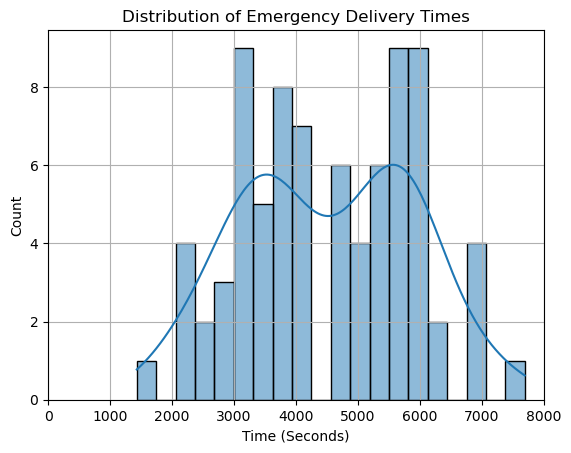


------------------------------ Scheduled Delivery Time ------------------------------
Average delivery time:         02h 35m 23s
Median delivery time:          02h 55m 07s
Max delivery time:             04h 16m 56s
Min delivery time:             50m 10s
75% of orders arrived in less than: 03h 15m 01s
90% of orders arrived in less than: 03h 55m 57s


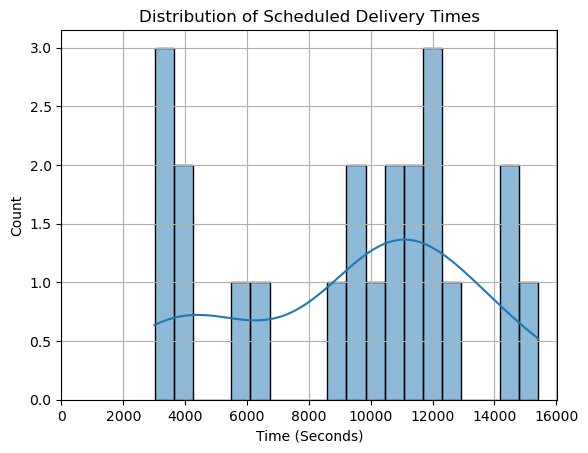


------------------------------ EOD Delivery Time ------------------------------
Average delivery time:         01h 04m 05s
Median delivery time:          54m 00s
Max delivery time:             02h 29m 12s
Min delivery time:             40m 38s
75% of orders arrived in less than: 01h 04m 06s
90% of orders arrived in less than: 01h 13m 53s


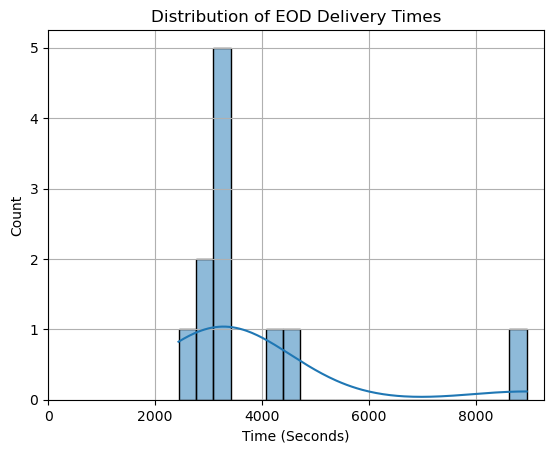

Total complete orders:    	 105/200   	 (52.50%)
Total on-time orders:     	 90/105 	 (45.00%)
Total on-time deliveries: 	 97/113 	 (85.84%)

Orders Completed - Emergency 	 74/76 	 (97.37%)
Orders Completed - Scheduled 	 21/58 	 (36.21%)
Orders Completed - EOD       	 10/66 	 (15.15%)

Orders On-time - Emergency 	 73/74 	 (98.65%)
Orders On-time - Scheduled 	 7/21 	 (33.33%)
Orders On-time - EOD       	 10/10 	 (100.00%)

Deliveries On-time - Emergency 	 79/80 	 (98.75%)
Deliveries On-time - Scheduled 	 7/22 	 (31.82%)
Deliveries On-time - EOD       	 11/11 	 (100.00%)



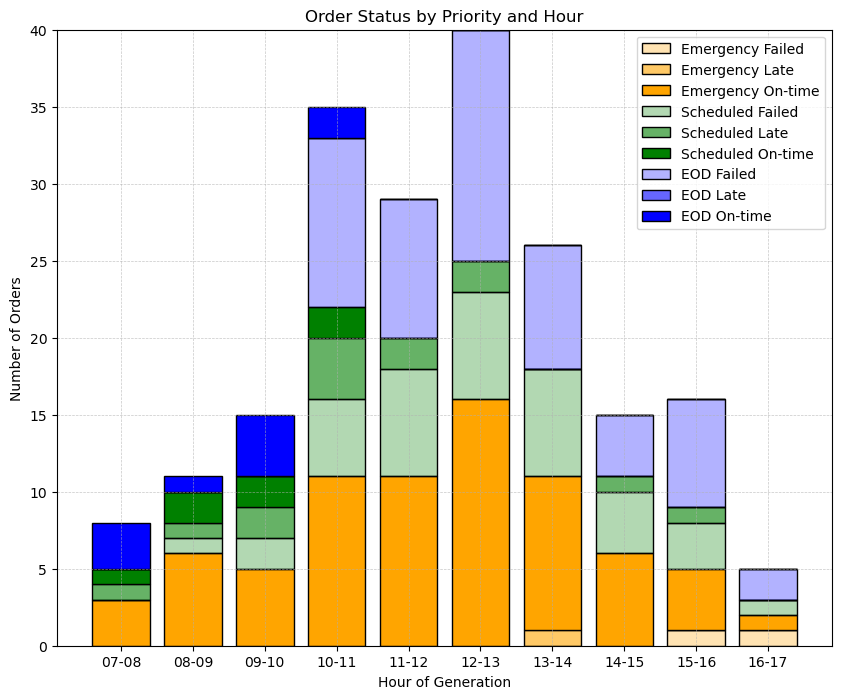

In [47]:
get_ontime_summary(caller, dispatcher)

### Resource Summary

In [48]:
def get_resource_summary(caller: Call, dispatcher: Dispatch):
    orders_df = orders2df(caller)
    deliveries_df = deliveries2df(dispatcher)

    # For each resource, compute usage counts and aggregated durations/metrics

    # Call Operators usage
    call_count = orders_df.groupby('CallOpID')['CallDuration'].count()
    call_duration = orders_df.groupby('CallOpID')['CallDuration'].sum()

    # Pick-up Operators usage
    pick_count = deliveries_df.groupby('PickOpID')['PickDuration'].count()
    pick_duration = deliveries_df.groupby('PickOpID')['PickDuration'].sum()

    # Assembly Operators usage
    assm_count = deliveries_df.groupby('AssmOpID')['AssmDuration'].count()
    assm_duration = deliveries_df.groupby('AssmOpID')['AssmDuration'].sum()

    # Launchers usage
    lnch_count = deliveries_df.groupby('LnchrID')['LnchDuration'].count()
    lnch_duration = deliveries_df.groupby('LnchrID')['LnchDuration'].sum()

    # Recovery Operators usage
    reco_count = deliveries_df.groupby('RecoOpID')['RecoDuration'].count()
    reco_duration = deliveries_df.groupby('RecoOpID')['RecoDuration'].sum()

    # Chargers usage
    chrg_count = deliveries_df.groupby('ChrgrID')['ChrgDuration'].count()
    chrg_duration = deliveries_df.groupby('ChrgrID')['ChrgDuration'].sum()

    # Drones (Zip) usage: count flights and total round-trip distance (Distance * 2)
    zip_count = deliveries_df.groupby('ZipID')['Distance(km)'].count()
    zip_distance = deliveries_df.groupby('ZipID').apply(lambda g: (g['Distance(km)'] * 2).sum())

    # Batteries usage: count usages, total flight duration (Inbound + Outbound) and total charging duration
    batt_count = deliveries_df.groupby('BattID')['OutboundDuration'].count()
    batt_usage_duration = deliveries_df.groupby('BattID').apply(lambda df: df['OutboundDuration'].sum() + df['InboundDuration'].sum())
    batt_charge_duration = deliveries_df.groupby('BattID')['ChrgDuration'].sum()

    # Print consolidated summary for each resource type
    print("Resource Usage Summary:")

    print("\nCall Operators:")
    for id, cnt in call_count.items():
        total_dur = call_duration.loc[id]
        print(f"Operator {id}: operated {cnt} times, total working duration: {TimeTick(total_dur).durtag}")

    print("\nPick-up Operators:")
    for id, cnt in pick_count.items():
        total_dur = pick_duration.loc[id]
        print(f"Operator {id}: operated {cnt} times, total working duration: {TimeTick(total_dur).durtag}")

    print("\nAssembly Operators:")
    for id, cnt in assm_count.items():
        total_dur = assm_duration.loc[id]
        print(f"Operator {id}: operated {cnt} times, total working duration: {TimeTick(total_dur).durtag}")

    print("\nLaunchers:")
    for id, cnt in lnch_count.items():
        total_dur = lnch_duration.loc[id]
        print(f"Launcher {id}: used {cnt} times, total duration: {TimeTick(total_dur).durtag}")

    print("\nRecovery Operators:")
    for id, cnt in reco_count.items():
        total_dur = reco_duration.loc[id]
        print(f"Operator {id}: operated {cnt} times, total working duration: {TimeTick(total_dur).durtag}")

    print("\nChargers:")
    for id, cnt in chrg_count.items():
        total_dur = chrg_duration.loc[id]
        print(f"Charger {id}: used {cnt} times, total charging duration: {TimeTick(total_dur).durtag}")

    print("\nDrones (Zip):")
    for id, cnt in zip_count.items():
        total_dist = zip_distance.loc[id]
        print(f"Zip {id}: used {cnt} times, total round-trip distance: {total_dist:.2f} km")

    print("\nBatteries:")
    for id, cnt in batt_count.items():
        usage_dur = batt_usage_duration.loc[id]
        charge_dur = batt_charge_duration.loc[id]
        print(f"Battery {id}: used {cnt} times, total flight duration: {TimeTick(usage_dur).durtag}, total charging duration: {TimeTick(charge_dur).durtag}")

In [49]:
get_resource_summary(caller, dispatcher)

Resource Usage Summary:

Call Operators:
Operator 0: operated 68 times, total working duration: 05h 49m 21s
Operator 1: operated 69 times, total working duration: 05h 37m 38s
Operator 2: operated 63 times, total working duration: 05h 23m 54s

Pick-up Operators:
Operator 0: operated 42 times, total working duration: 05h 01m 01s
Operator 1: operated 35 times, total working duration: 04h 19m 59s
Operator 2: operated 36 times, total working duration: 04h 26m 08s

Assembly Operators:
Operator 0: operated 113 times, total working duration: 05h 39m 25s

Launchers:
Launcher 0: used 113 times, total duration: 36m 10s

Recovery Operators:
Operator 0: operated 113 times, total working duration: 03h 45m 25s

Chargers:
Charger 0: used 6 times, total charging duration: 02h 54m 15s
Charger 1: used 6 times, total charging duration: 02h 25m 20s
Charger 2: used 6 times, total charging duration: 03h 06m 48s
Charger 3: used 6 times, total charging duration: 03h 08m 25s
Charger 4: used 6 times, total charg

C:\Users\XuZJ\AppData\Local\Temp\ipykernel_30848\13648600.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zip_distance = deliveries_df.groupby('ZipID').apply(lambda g: (g['Distance(km)'] * 2).sum())
C:\Users\XuZJ\AppData\Local\Temp\ipykernel_30848\13648600.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  batt_usage_duration = deliveries_df.groupby('BattID').apply(lambda df: df['OutboundDuration'].s